In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None

In [4]:
from empleados_package.visualizacion import PROJECT_ROOT_DIR, IMAGES_PATH, save_fig, mapa_calor, boxplot
from empleados_package.outliers import eliminar_outliers

# ANÁLISIS EXPLORATORIO Y LIMPIEZA

Comenzaremos transformado el csv en dataframe para analizarlo y proceder a su limpieza.

La limpieza estará orientada a la visualización de los datos y su ingesta en una base de datos relacional sql, de modo que nos centraremos en que sean del tipo correcto, que los strings tengan una tipografía y una nomenclatura unificadas, y eliminaremos las columnas que contenga datos irrelevantes o tan pocos datos que su contenido no nos aporte información útil. Se tratarán los dupicados y los nulos por ahora, pero estos últimos sólo se sustituirán en la columna MONTHLY_INCOME basándonos en su relación con JOB_LEVEL, dado que el objetivo en este primer paso no es aplicar algoritmos de machine learning.

Como resultado de esta limpieza obtendremos tres ficheros .csv:
* **empleados_limpio.csv** será el resultado de la limpieza y con él se montará la base de datos.

* **empleados_tristes.csv** y **empleados_felices.csv** contendrá respectivamente la información de los empleados satisfechos e insatisfechos.

* **empleados_visualizacion.csv** será **empleados_limpio.csv** sin outliers y con él se realizará la visualización.

In [5]:
df = pd.read_csv("./data/empleados.csv", index_col = 0)

Comenzaremos echando un vistazoa  nuestros datos

In [6]:
df.head(10)

Age Attrition     BusinessTravel DailyRate                Department  \
0  51        No                NaN    684,0$                       NaN   
1  52        No                NaN    699,0$                       NaN   
2  42        No      travel_rarely    532,0$   Research & Development    
3  47        No      travel_rarely    359,0$                       NaN   
4  46        No                NaN   1319,0$                       NaN   
5  48        No                NaN    117,0$   Research & Development    
6  59        No                NaN   1435,0$                       NaN   
7  42        No      travel_rarely    635,0$                       NaN   
8  41        No                NaN   1276,0$                       NaN   
9  41        No  travel_frequently    840,0$                       NaN   

   DistanceFromHome  Education    EducationField  employeecount  \
0                 6          3               NaN              1   
1                 1          4     Life Sciences              1   
2                 4          2  Technical Degree              1   
3                 2          4           Medical              1   
4                 3          3  Technical Degree              1   
5                22          3           Medical              1   
6                25          3     Life Sciences              1   
7                 1          1               NaN              1   
8                 2          5               NaN              1   
9                 9          3               NaN              1   

  employeenumber  EnvironmentSatisfaction  Gender HourlyRate  JobInvolvement  \
0          162,0                        1       0         51               3   
1          259,0                        3       0         65               2   
2          319,0                        3       0         58               3   
3            NaN                        1       1         82               3   
4            NaN                        1       1         45               4   
5         1900,0                        4       1         58               3   
6           81,0                        1       1         99               3   
7          387,0                        2       0         99               3   
8            NaN                        2       1         91               3   
9          999,0                        1       0         64               3   

   JobLevel              JobRole  JobSatisfaction MaritalStatus MonthlyIncome  \
0         5   resEArch DIREcToR                 3           NaN       19537,0   
1         5             ManAGeR                 3           NaN       19999,0   
2         5             ManaGER                 4       Married       19232,0   
3         4   ReseArCH DIrECtOr                 3       Married       17169,0   
4         4     sAleS EXECUtIve                 1      Divorced           NaN   
5         4             MANAger                 4           NaN       17174,0   
6         3     Sales ExeCutIVe                 1           NaN           NaN   
7         2     Sales eXEcUTiVe                 3       Married           NaN   
8         4             mANAGEr                 1       Married       16595,0   
9         5   reSEaRCH DIrectoR                 3           NaN           NaN   

   MonthlyRate  NUMCOMPANIESWORKED Over18 OverTime  PercentSalaryHike  \
0         6462                   7      Y       No                 13   
1         5678                   0    NaN      NaN                 14   
2         4933                   1    NaN       No                 11   
3        26703                   3      Y      NaN                 19   
4         7739                   2      Y       No                 12   
5         2437                   3    NaN       No                 11   
6         2354                   7      Y      NaN                 11   
7        24532                   1    NaN       No                 25   
8         5626     

In [7]:
df.shape

(1614, 41)

In [8]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'employeecount',
       'employeenumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NUMCOMPANIESWORKED',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TOTALWORKINGYEARS', 'TrainingTimesLastYear', 'WORKLIFEBALANCE',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YEARSWITHCURRMANAGER', 'SameAsMonthlyIncome', 'DateBirth', 'Salary',
       'RoleDepartament', 'NUMBERCHILDREN', 'RemoteWork'],
      dtype='object')

Vamos a cambiar el nombre de las columnas a snake_case y en mayúsculas.

In [9]:
columns_snake = ['Age', 'Attrition', 'Business_travel', 'Daily_rate', 'Department',
       'Distance_from_home', 'Education', 'Education_field', 'Employee_count',
       'Employee_number', 'Environment_Satisfaction', 'Gender', 'Hourly_Rate',
       'Job_Involvement', 'Job_Level', 'Job_Role', 'Job_Satisfaction',
       'Marital_Status', 'Monthly_Income', 'Monthly_Rate', 'NUM_COMPANIES_WORKED',
       'Over_18', 'Over_Time', 'Percent_Salary_Hike', 'Performance_Rating',
       'Relationship_Satisfaction', 'Standard_Hours', 'Stock_Option_Level',
       'TOTAL_WORKING_YEARS', 'Training_Times_Last_Year', 'WORK_LIFE_BALANCE',
       'Years_At_Company', 'Years_In_Current_Role', 'Years_Since_Last_Promotion',
       'YEARS_WITH_CURR_MANAGER', 'Same_As_Monthly_Income', 'Date_Birth', 'Salary',
       'Role_Departament', 'NUMBER_CHILDREN', 'Remote_Work']

In [10]:
columns_upper = [i.upper() for i in columns_snake]

In [11]:
df.columns = columns_upper

In [12]:
df.head()

AGE ATTRITION BUSINESS_TRAVEL DAILY_RATE                DEPARTMENT  \
0  51        No             NaN     684,0$                       NaN   
1  52        No             NaN     699,0$                       NaN   
2  42        No   travel_rarely     532,0$   Research & Development    
3  47        No   travel_rarely     359,0$                       NaN   
4  46        No             NaN    1319,0$                       NaN   

   DISTANCE_FROM_HOME  EDUCATION   EDUCATION_FIELD  EMPLOYEE_COUNT  \
0                   6          3               NaN               1   
1                   1          4     Life Sciences               1   
2                   4          2  Technical Degree               1   
3                   2          4           Medical               1   
4                   3          3  Technical Degree               1   

  EMPLOYEE_NUMBER  ENVIRONMENT_SATISFACTION  GENDER HOURLY_RATE  \
0           162,0                         1       0          51   
1           259,0                         3       0          65   
2           319,0                         3       0          58   
3             NaN                         1       1          82   
4             NaN                         1       1          45   

   JOB_INVOLVEMENT  JOB_LEVEL             JOB_ROLE  JOB_SATISFACTION  \
0                3          5   resEArch DIREcToR                  3   
1                2          5             ManAGeR                  3   
2                3          5             ManaGER                  4   
3                3          4   ReseArCH DIrECtOr                  3   
4                4          4     sAleS EXECUtIve                  1   

  MARITAL_STATUS MONTHLY_INCOME  MONTHLY_RATE  NUM_COMPANIES_WORKED OVER_18  \
0            NaN        19537,0          6462                     7       Y   
1            NaN        19999,0          5678                     0     NaN   
2        Married        19232,0          4933                     1     NaN   
3        Married        17169,0         26703                     3       Y   
4       Divorced            NaN          7739                     2       Y   

  OVER_TIME  PERCENT_SALARY_HIKE PERFORMANCE_RATING  \
0        No                   13                3,0   
1       NaN                   14                3,0   
2        No                   11                3,0   
3       NaN                   19                3,0   
4        No                   12                3,0   

   RELATIONSHIP_SATISFACTION STANDARD_HOURS  STOCK_OPTION_LEVEL  \
0                          3            NaN                   0   
1                          1            NaN                   1   
2                          4            NaN                   0   
3                          2            NaN                   2   
4                          4            NaN                   1   

  TOTAL_WORKING_YEARS  TRAINING_TIMES_LAST_YEAR WORK_LIFE_BALANCE  \
0                 NaN                         5               3,0   
1                34,0                         5               3,0   
2                22,0                         3               NaN   
3                 NaN                         2               NaN   
4                 NaN                         5               3,0   

   YEARS_AT_COMPANY YEARS_IN_CURRENT_ROLE  YEARS_SINCE_LAST_PROMOTION  \
0                20                   NaN                          15   
1                33                   NaN                          11   
2                22                   NaN                          11   
3                20                   NaN                           5   
4                19                   NaN                           2   

   YEARS_WITH_CURR_MANAGER SAME_AS_MONTHLY_INCOME  DATE_BIRTH       SALARY  \
0                       15                19537,0        1972  1000000000$   
1                        9                19999,0        1971  1000000000$   
2              

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1614 entries, 0 to 1613
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AGE                         1614 non-null   object 
 1   ATTRITION                   1614 non-null   object 
 2   BUSINESS_TRAVEL             842 non-null    object 
 3   DAILY_RATE                  1614 non-null   object 
 4   DEPARTMENT                  302 non-null    object 
 5   DISTANCE_FROM_HOME          1614 non-null   int64  
 6   EDUCATION                   1614 non-null   int64  
 7   EDUCATION_FIELD             869 non-null    object 
 8   EMPLOYEE_COUNT              1614 non-null   int64  
 9   EMPLOYEE_NUMBER             1183 non-null   object 
 10  ENVIRONMENT_SATISFACTION    1614 non-null   int64  
 11  GENDER                      1614 non-null   int64  
 12  HOURLY_RATE                 1614 non-null   object 
 13  JOB_INVOLVEMENT             1614 non-n

## Columnas numéricas

Parece haber bastantes columnas con el tipo de dato erroneo, por ejemplo 'AGE' debería de ser un entero. También 'DAILY_RATE' y ', 'SALARY', que además tiene un símbolo de dolar que tendremos que eliminar.

Vamos a comprobar los valores únicos de estas columnas y a solucionar este problema de tipos de dato. También a eliminar las columnas 'SAME_AS_MONTHLY_INCOME', que es redundante, y 'EMPLOYEE_NUMBER', que contiene nulos y no nos es útil.

In [14]:
df_types = df.drop(['SAME_AS_MONTHLY_INCOME', 'EMPLOYEE_NUMBER'], axis=1)

In [15]:
integer = ['AGE', 'HOURLY_RATE', 'STANDARD_HOURS', 'TOTAL_WORKING_YEARS', 'WORK_LIFE_BALANCE', 'YEARS_IN_CURRENT_ROLE', 'NUMBER_CHILDREN']
float = ['MONTHLY_INCOME', 'PERFORMANCE_RATING']
dollar = ['DAILY_RATE', 'SALARY']

In [16]:
print('\n'.join(f"{i} {df_types[i].unique()}" for i in integer))

AGE ['51' '52' '42' '47' '46' '48' '59' '41' '56' '38' '55' '40' '58' '35'
 '45' '33' '36' '34' 'forty-seven' '53' '43' '60' '32' '37' '49' '39' '50'
 '44' '30' 'fifty-eight' '29' '31' '54' '57' '27' 'thirty-six' '28' '26'
 'fifty-five' '25' 'fifty-two' 'thirty-one' '24' 'thirty' '23' '22' '21'
 '20' 'twenty-six' '19' 'thirty-seven' '18' 'thirty-two' 'twenty-four']
HOURLY_RATE ['51' '65' '58' '82' '45' '99' '91' '64' '55' '68' '49' '61' '79' '31'
 '69' '48' '80' '74' '98' '59' '33' '56' '66' '57' '53' '87' '81' '84'
 '32' '41' '92' '47' 'Not Available' '43' '86' '30' '42' '88' '96' '67'
 '62' '72' '78' '89' '52' '50' '90' '37' '94' '76' '60' '46' '83' '100'
 '40' '97' '54' '75' '39' '85' '63' '44' '93' '36' '35' '73' '71' '70'
 '38' '77' '95' '34']
STANDARD_HOURS [nan '80,0']
TOTAL_WORKING_YEARS [nan '34,0' '22,0' '28,0' '20,0' '21,0' '33,0' '40,0' '18,0' '25,0' '15,0'
 '17,0' '26,0' '16,0' '24,0' '14,0' '23,0' '27,0' '19,0' '11,0' '38,0'
 '37,0' '13,0' '12,0' '29,0' '10,0' '36,0' '35,

In [17]:
print('\n'.join(f"{i} {df_types[i].unique()}" for i in float))

MONTHLY_INCOME ['19537,0' '19999,0' '19232,0' '17169,0' nan '17174,0' '16595,0' '19973,0'
 '13402,0' '13206,0' '19545,0' '18041,0' '19246,0' '10748,0' '16752,0'
 '6201,0' '19845,0' '4001,0' '10447,0' '16064,0' '3210,0' '10266,0'
 '10475,0' '6162,0' '4721,0' '4615,0' '16959,0' '10306,0' '5406,0'
 '5902,0' '10855,0' '5914,0' '6646,0' '13973,0' '13320,0' '6687,0'
 '4735,0' '13872,0' '19045,0' '16015,0' '9613,0' '11510,0' '4306,0'
 '17046,0' '5067,0' '3692,0' '19847,0' '2308,0' '5747,0' '10422,0'
 '6347,0' '2348,0' '3072,0' '12490,0' '8020,0' '17068,0' '8943,0'
 '19272,0' '5577,0' '2691,0' '7403,0' '8823,0' '3579,0' '17779,0'
 '18213,0' '13577,0' '19190,0' '17123,0' '19187,0' '10008,0' '7988,0'
 '7083,0' '4723,0' '3407,0' '2929,0' '12031,0' '15427,0' '5126,0' '9619,0'
 '5010,0' '19033,0' '10400,0' '2793,0' '5674,0' '19197,0' '8412,0'
 '3348,0' '5309,0' '7654,0' '12808,0' '6586,0' '2519,0' '17099,0'
 '13120,0' '3131,0' '4444,0' '6674,0' '9852,0' '17861,0' '7446,0'
 '13757,0' '16598,0' '4285

In [18]:
print('\n'.join(f"{i} {df_types[i].unique()}" for i in dollar))

DAILY_RATE ['684,0$' '699,0$' '532,0$' '359,0$' '1319,0$' '117,0$' '1435,0$' '635,0$'
 '1276,0$' '840,0$' '247,0$' '1369,0$' '201,0$' '1360,0$' '692,0$'
 '1398,0$' '286,0$' '1402,0$' '819,0$' '884,0$' '1238,0$' '515,0$'
 '1223,0$' '202,0$' '928,0$' '607,0$' '266,0$' '429,0$' '589,0$' 'nan$'
 '1180,0$' '1282,0$' '776,0$' '665,0$' '526,0$' '1034,0$' '1403,0$'
 '1499,0$' '580,0$' '859,0$' '263,0$' '1376,0$' '885,0$' '1003,0$'
 '1321,0$' '394,0$' '1372,0$' '1333,0$' '228,0$' '737,0$' '823,0$'
 '667,0$' '301,0$' '573,0$' '1329,0$' '630,0$' '1063,0$' '1017,0$'
 '1296,0$' '939,0$' '1355,0$' '1448,0$' '200,0$' '1202,0$' '404,0$'
 '208,0$' '813,0$' '465,0$' '1189,0$' '1001,0$' '1394,0$' '161,0$'
 '288,0$' '682,0$' '1354,0$' '147,0$' '119,0$' '1413,0$' '452,0$' '334,0$'
 '1132,0$' '982,0$' '480,0$' '1099,0$' '672,0$' '1379,0$' '583,0$'
 '1492,0$' '1050,0$' '469,0$' '237,0$' '1440,0$' '1291,0$' '1157,0$'
 '1336,0$' '1224,0$' '735,0$' '1389,0$' '638,0$' '1240,0$' '194,0$'
 '1339,0$' '111,0$' '1469

Tras comprobar los valores únicos constatamos que:

* La columna AGE tiene cifras escritas con letras que debemos cambiar antes de transformar el tipo de dato.

* La columna STANDARD_HOURS contiene el valor 80,0 o nan para todos los registros por lo que es inútil a efectos de análsis y ml, de modo que puede ser eliminada.

* La columna SALARY contiene el mismo valor para todos los registros y es inútil a efectos de análsis y ml, de modo que puede ser eliminada.

* Todos los valores de la columna NUMBER_CHILDREN son nulos y puede ser eliminada.

* Las columnas 'MONTHLY_INCOME' y 'PERFORMANCE_RATING' tienen coma para indicar los decimales, habrá que sustituir la coma por punto.

* La columna 'DAILY_RATE', además de tener coma para indicar los decimales que habrá  que sustituir por punto, tiene al final del string el símbolo $; eliminaremos también el dollar.

* Sustituiremos los 'Not Available' de 'HOURLY_RATE' por NaN.

In [19]:
# Eliminamos columnas
df_types = df_types.drop(['STANDARD_HOURS', 'SALARY', 'NUMBER_CHILDREN'], axis=1)

In [20]:
# Sacamos los valores escritos con letras de AGE

letras = [i for i in df['AGE'] if len(i)>2]
letras

['forty-seven',
 'fifty-eight',
 'thirty-six',
 'fifty-five',
 'fifty-two',
 'thirty-one',
 'thirty',
 'twenty-six',
 'thirty-seven',
 'thirty-two',
 'twenty-four',
 'thirty-two']

In [21]:
# Creamos un diccionario con los valores a sustituir

dict_num = {'forty-seven': '47',
 'fifty-eight': '58',
 'thirty-six': '36',
 'fifty-five': '55',
 'fifty-two': '52',
 'thirty-one': '31',
 'thirty': '30',
 'twenty-six': '26',
 'thirty-seven': '37',
 'thirty-two': '32',
 'twenty-four': '24'}

In [22]:
# Aplicamos map al diccionario que acabamos de crear

df_types['AGE'] = df_types['AGE'].replace(dict_num)

In [23]:
# Comprobamos que la transformación se realizó con éxito
df_types['AGE'].unique()

array(['51', '52', '42', '47', '46', '48', '59', '41', '56', '38', '55',
       '40', '58', '35', '45', '33', '36', '34', '53', '43', '60', '32',
       '37', '49', '39', '50', '44', '30', '29', '31', '54', '57', '27',
       '28', '26', '25', '24', '23', '22', '21', '20', '19', '18'],
      dtype=object)

Ahora vamos a sustituir las comas por punto y cambiar el dato a entero

In [24]:
num_coma = ['TOTAL_WORKING_YEARS', 'WORK_LIFE_BALANCE', 'YEARS_IN_CURRENT_ROLE', 'MONTHLY_INCOME', 'PERFORMANCE_RATING']

In [25]:
for column_name in num_coma:
    
    print(f"Procesando columna: {column_name}")
    df_types[column_name] = pd.to_numeric(df_types[column_name].str.replace(',', '.'), errors='coerce')


Procesando columna: TOTAL_WORKING_YEARS
Procesando columna: WORK_LIFE_BALANCE
Procesando columna: YEARS_IN_CURRENT_ROLE
Procesando columna: MONTHLY_INCOME
Procesando columna: PERFORMANCE_RATING


Pasamos 'AGE' y 'HOURLY_RATE'  a entero, sustituyendo los 'Not Available' de 'HOURLY_RATE' por NaN

In [26]:
df_types[['AGE', 'HOURLY_RATE']] = df_types[['AGE', 'HOURLY_RATE']].replace('Not Available', np.nan).apply(pd.to_numeric).astype('Int64')

Tan solo falta cambiar 'DAILY_RATE', que además de la coma tiene el símbolo del dollar

In [27]:
df_types['DAILY_RATE'] = df_types['DAILY_RATE'].apply(lambda x: str(x).replace('$', ''))

In [28]:
#df_types['DAILY_RATE'] = df_types['DAILY_RATE'].replace('nan', np.nan).apply(lambda x: int(str(x).replace(',', '.')) if pd.notna(x) else x)
df_types['DAILY_RATE'] = pd.to_numeric(df_types['DAILY_RATE'].str.replace(',', '.'), errors='coerce')

Siguiendo con el estudio de los datos vemos que hay otras cinco columnas que pueden ser eliminadas:

* 'OVER_18' tiene nulos y su información puede ser obtenida de la columna 'AGE', que ahora que ya está con sus datos en enteros, podemos comprobar que todos los empleados son mayores de edad, ya que su valor mínimo es 18.

* Las columnas 'DEPARTMENT', 'ROLE_DEPARTAMENT' y 'YEARS_IN_CURRENT_ROLE' tienen tal cantidad de nulos, que no merece la pena mantenerlas.

* 'EMPLOYEE_COUNT' contiene el valor 1 para todas las filas.

In [29]:
# Comprobamos la edad mínima de los empleados
print(df_types['AGE'].min())

18


In [30]:
# Eliminamos la columnas indeseadas
df_types = df_types.drop(['DEPARTMENT', 'ROLE_DEPARTAMENT', 'YEARS_IN_CURRENT_ROLE', 'OVER_18', 'EMPLOYEE_COUNT'], axis=1)

In [31]:
#Comprobamos que los datos han cambiado correctamente
df_types.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1614 entries, 0 to 1613
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AGE                         1614 non-null   Int64  
 1   ATTRITION                   1614 non-null   object 
 2   BUSINESS_TRAVEL             842 non-null    object 
 3   DAILY_RATE                  1490 non-null   float64
 4   DISTANCE_FROM_HOME          1614 non-null   int64  
 5   EDUCATION                   1614 non-null   int64  
 6   EDUCATION_FIELD             869 non-null    object 
 7   ENVIRONMENT_SATISFACTION    1614 non-null   int64  
 8   GENDER                      1614 non-null   int64  
 9   HOURLY_RATE                 1530 non-null   Int64  
 10  JOB_INVOLVEMENT             1614 non-null   int64  
 11  JOB_LEVEL                   1614 non-null   int64  
 12  JOB_ROLE                    1614 non-null   object 
 13  JOB_SATISFACTION            1614 non-n

Vamos a ver una descripción de los datos numéricos

In [32]:
df_types.describe().T

count          mean          std     min     25%  \
AGE                         1614.0     36.920694     9.102157    18.0    30.0   
DAILY_RATE                  1490.0    802.085235   403.246954   103.0  468.25   
DISTANCE_FROM_HOME          1614.0      4.527261    14.591913   -49.0     2.0   
EDUCATION                   1614.0      2.925031     1.022357     1.0     2.0   
ENVIRONMENT_SATISFACTION    1614.0      4.294919     6.993559     1.0     2.0   
GENDER                      1614.0      0.398389     0.489718     0.0     0.0   
HOURLY_RATE                 1530.0     66.028105    20.185954    30.0    48.0   
JOB_INVOLVEMENT             1614.0      2.739777     0.711567     1.0     2.0   
JOB_LEVEL                   1614.0      2.068154     1.101344     1.0     1.0   
JOB_SATISFACTION            1614.0      2.738538     1.106163     1.0     2.0   
MONTHLY_INCOME               771.0   6477.686122  4766.119959  1009.0  2880.0   
MONTHLY_RATE                1614.0  14284.495663  7110.414585  2094.0  8001.0   
NUM_COMPANIES_WORKED        1614.0      2.673482     2.506152     0.0     1.0   
PERCENT_SALARY_HIKE         1614.0     15.165428      3.64861    11.0    12.0   
PERFORMANCE_RATING          1419.0       3.15081      0.35799     3.0     3.0   
RELATIONSHIP_SATISFACTION   1614.0      2.704461     1.079031     1.0     2.0   
STOCK_OPTION_LEVEL          1614.0      0.791202     0.842396     0.0     0.0   
TOTAL_WORKING_YEARS         1088.0     11.318934     7.727675     0.0     6.0   
TRAINING_TIMES_LAST_YEAR    1614.0      2.809789     1.297765     0.0     2.0   
WORK_LIFE_BALANCE           1506.0      2.759628     0.702622     1.0     2.0   
YEARS_AT_COMPANY            1614.0       7.13259     6.124237     0.0     3.0   
YEARS_SINCE_LAST_PROMOTION  1614.0      2.245973     3.235665     0.0     0.0   
YEARS_WITH_CURR_MANAGER     1614.0       4.22057     3.562695     0.0     2.0   
DATE_BIRTH                  1614.0   1986.076208     9.101332  1963.0  1980.0   

                                50%      75%      max  
AGE                            36.0     43.0     60.0  
DAILY_RATE                    798.0   1157.0   1499.0  
DISTANCE_FROM_HOME              5.0     11.0     29.0  
EDUCATION                       3.0      4.0      5.0  
ENVIRONMENT_SATISFACTION        3.0      4.0     49.0  
GENDER                          0.0      1.0      1.0  
HOURLY_RATE                    66.0     84.0    100.0  
JOB_INVOLVEMENT                 3.0      3.0      4.0  
JOB_LEVEL                       2.0      3.0      5.0  
JOB_SATISFACTION                3.0      4.0      4.0  
MONTHLY_INCOME               4859.0   8230.5  19999.0  
MONTHLY_RATE                14248.5  20364.0  26999.0  
NUM_COMPANIES_WORKED            2.0      4.0      9.0  
PERCENT_SALARY_HIKE            14.0     18.0     25.0  
PERFORMANCE_RATING              3.0      3.0      4.0  
RELATIONSHIP_SATISFACTION       3.0      4.0      4.0  
STOCK_OPTION_LEVEL              1.0      1.0      3.0  
TOTAL_WORKING_YEARS            10.0     15.0     40.0  
TRAINING_TIMES_LAST_YEAR        3.0      3.0      6.0  
WORK_LIFE_BALANCE               3.0      3.0      4.0  
YEARS_AT_COMPANY                5.0      9.0     40.0  
YEARS_SINCE_LAST_PROMOTION      1.0      3.0     15.0  
YEARS_WITH_CURR_MANAGER         3.0      7.0     17.0  
DATE_BIRTH                   1987.0   1993.0   2005.0

Podemos constatar que la columna 'DISTANCE_FROM_HOME' tiene valores negativos, lo cual no tiene mucho sentido, de modo que vamos a tomar el valor absoluto de sus cifras

In [33]:
df_types['DISTANCE_FROM_HOME'] = df_types['DISTANCE_FROM_HOME'].abs()

## Salario
Hay varias columnas que se refieren al salario percibido y merecen una atención especial, tanto por el gran impacto que esta cifra tiene sobre la satisfacción de los empleados, como para dirimir si todas son necesarias o nos aportan datos redundantes.

In [34]:
df_salario = df_types[['HOURLY_RATE', 'DAILY_RATE', 'MONTHLY_RATE', 'MONTHLY_INCOME']]

In [35]:
df_salario.head()

HOURLY_RATE  DAILY_RATE  MONTHLY_RATE  MONTHLY_INCOME
0           51       684.0          6462         19537.0
1           65       699.0          5678         19999.0
2           58       532.0          4933         19232.0
3           82       359.0         26703         17169.0
4           45      1319.0          7739             NaN

Las columnas 'HOURLY_RATE', 'DAILY_RATE' y 'MONTHLY_RATE' están relacionadas entre sí y podemos prescindir de dos, nos vamos a quedar con el sueldo mensual 'MONTHLY_RATE':

* DAILY_RATE = HOURLY_RATE * Average_hours_per_day

* MONTHLY_RATE = DAILY_RATE * Average_working_days_per_month

Con 'MONTHLY_INCOME' la cosa cambia, porque es la suma del salario mas otras fuentes de ingresos y beneficios, como comisiones de venta, de ahí que ambos valores puedan llegar a diferir de manera notable. Además tiene el problema de que tiene una cantidad importante de nulos, pero antes de hacer nada con ella, vamos a ver cómo se relacione con el resto de variables.

In [36]:
# Eliminamos las columnas 'HOURLY_RATE' y 'DAILY_RATE'
df_types = df_types.drop(['HOURLY_RATE', 'DAILY_RATE'], axis=1)

Saving figure corr_heatmap_1


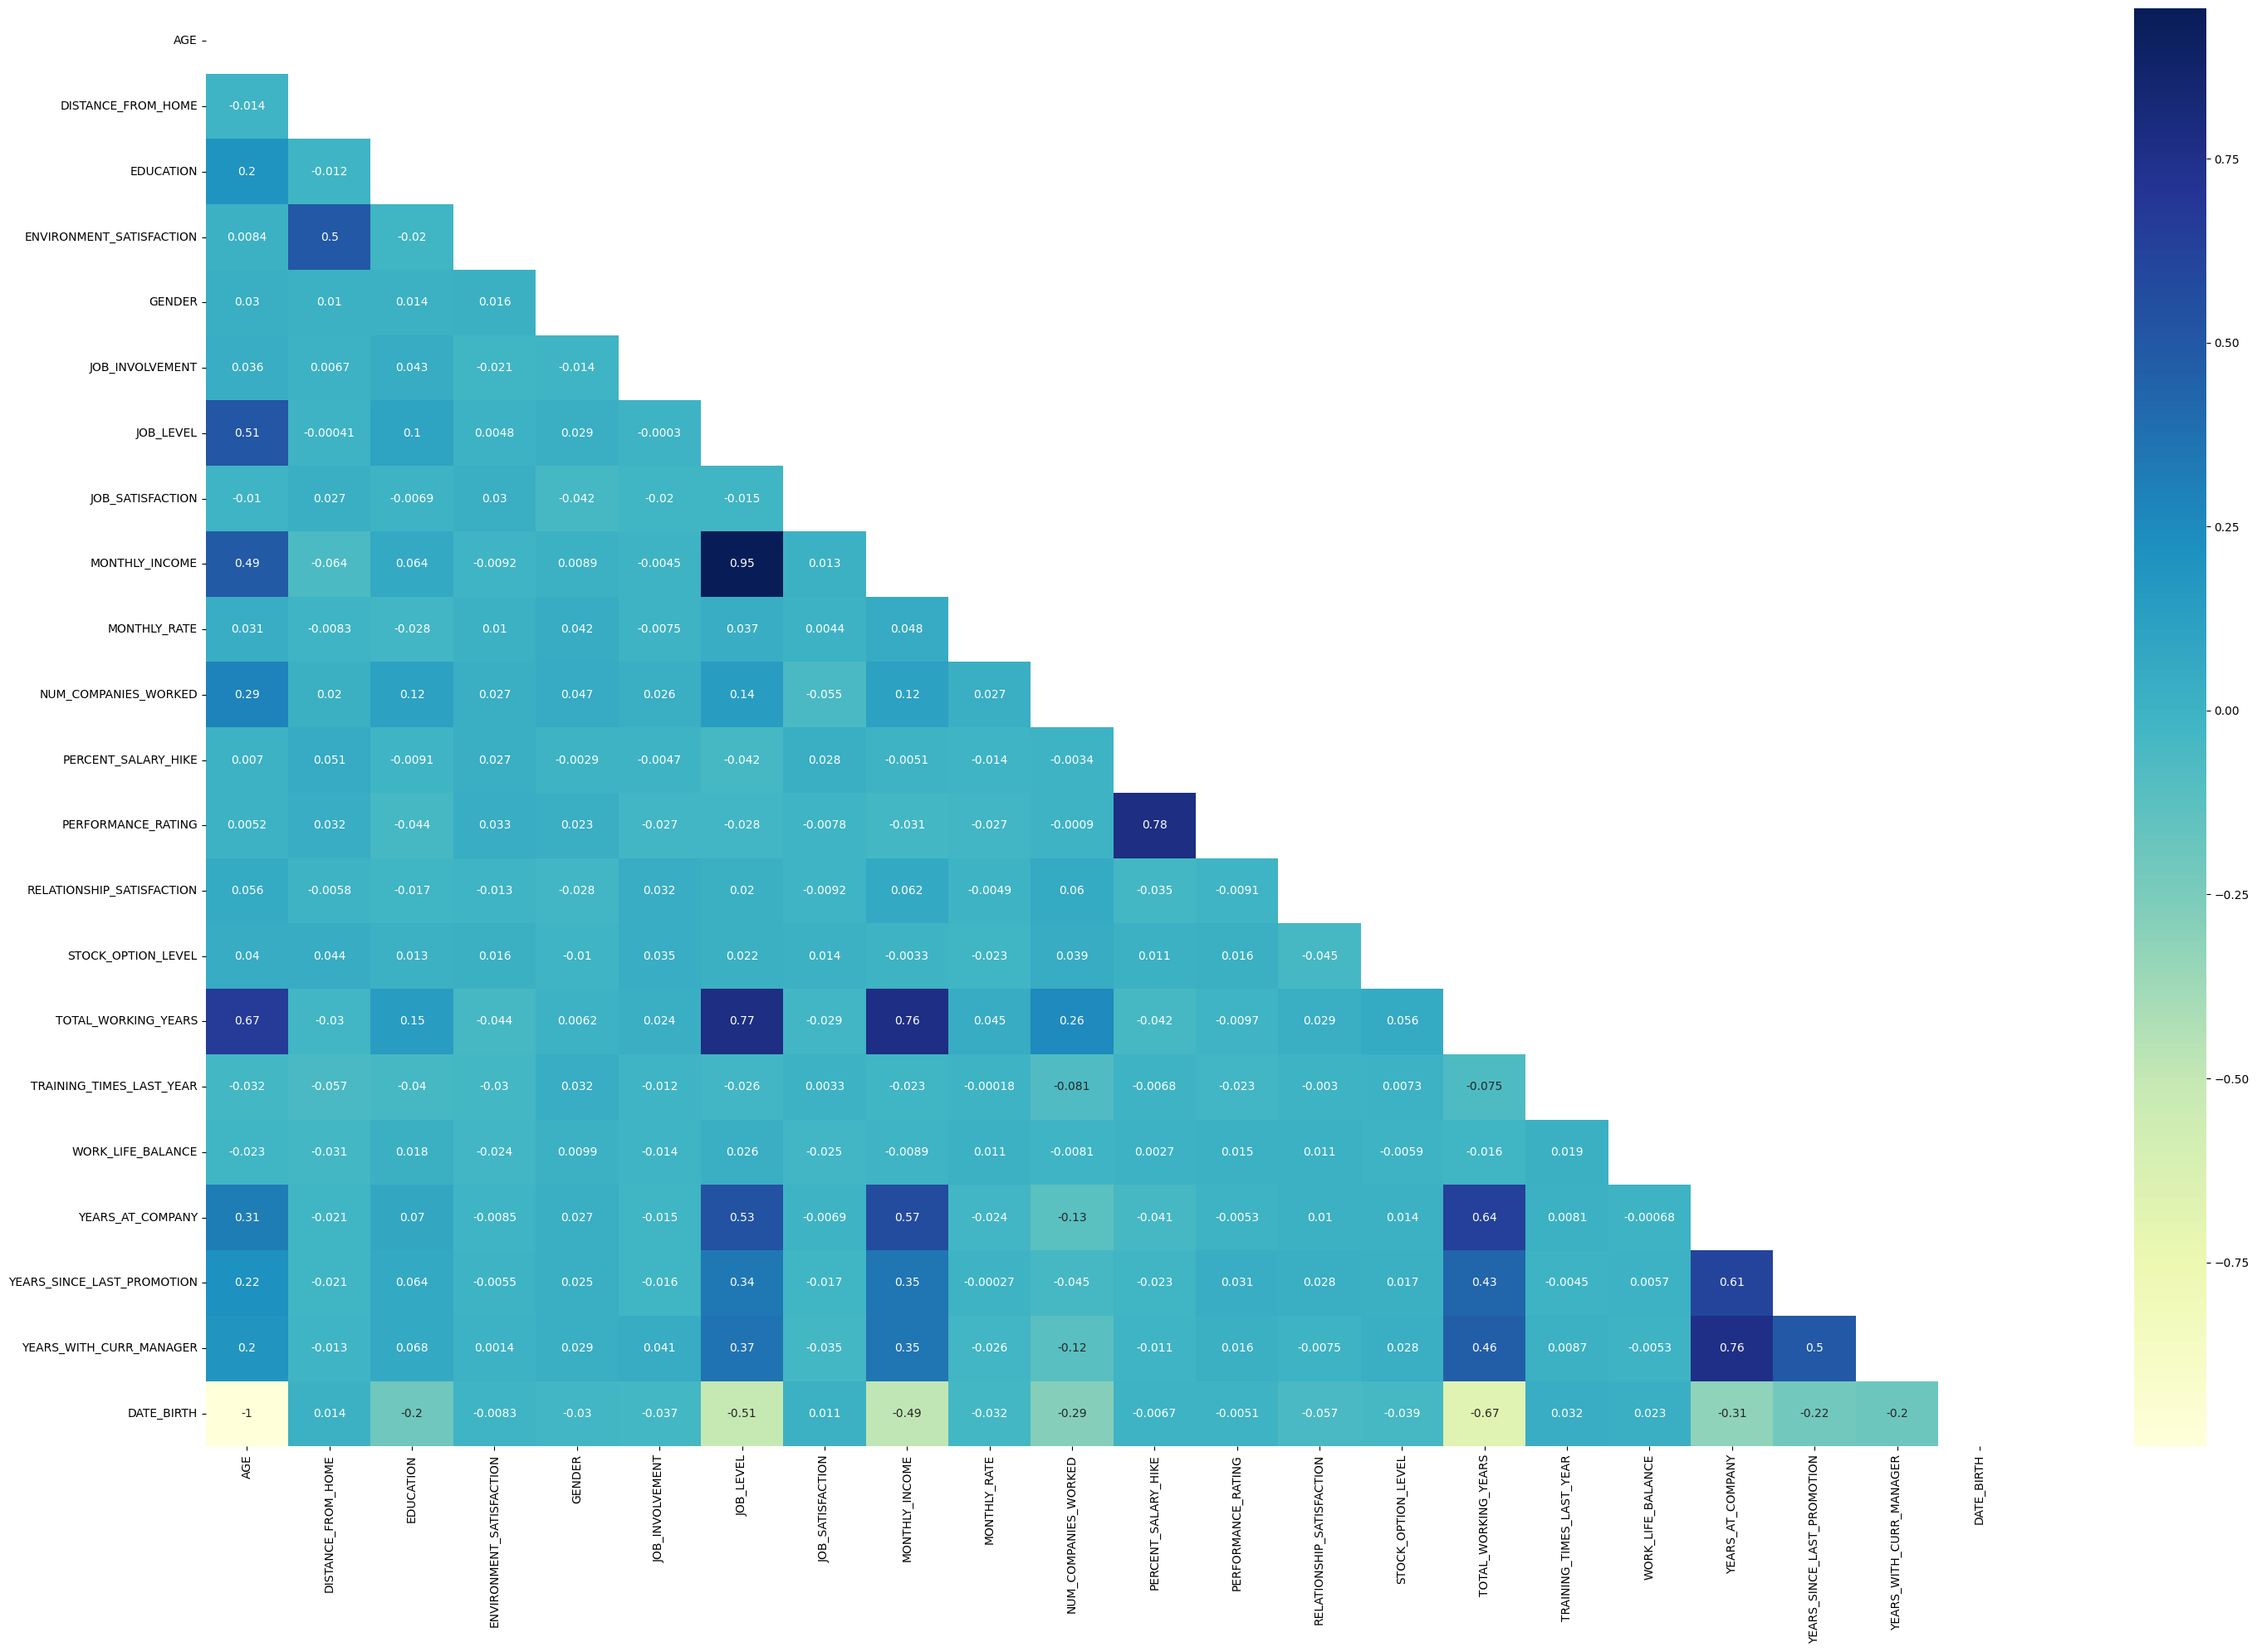

In [37]:
mapa_calor(df_types, nombre_fichero="corr_heatmap_1")

En este gráfico se observa una fuerte correlación entre 'MONTHLY_INCOME' y 'JOB_LEVEL', de modo que a lo mejor podemos aprovechar el segundo, que no tiene nulos, para completar los datos del primero

In [38]:
df_level_income = df_types[['JOB_LEVEL', 'MONTHLY_INCOME']]

In [39]:
df_level_income.head()

JOB_LEVEL  MONTHLY_INCOME
0          5         19537.0
1          5         19999.0
2          5         19232.0
3          4         17169.0
4          4             NaN

In [40]:
df_level_income_grouped = df_level_income.groupby('JOB_LEVEL').agg(['mean', 'median', 'count'])

In [41]:
df_level_income_grouped.head()

MONTHLY_INCOME               
                    mean   median count
JOB_LEVEL                              
1            2811.113402   2683.0   291
2            5391.410714   5304.0   280
3           10007.184466  10124.0   103
4           15340.706897  16015.0    58
5           19132.461538  19197.0    39

Aunque en la mayoría de los casos la media no difiere demasiado de la quizá sea más prudente usar la mediana, dado que un trabajador concreto con un sueldo extraordinariamente alto o bajo para su categoría, puede desviarnos toda la estadística. Vamos a asegurarnos comprobando los outliers.

Saving figure boxplot_job_level


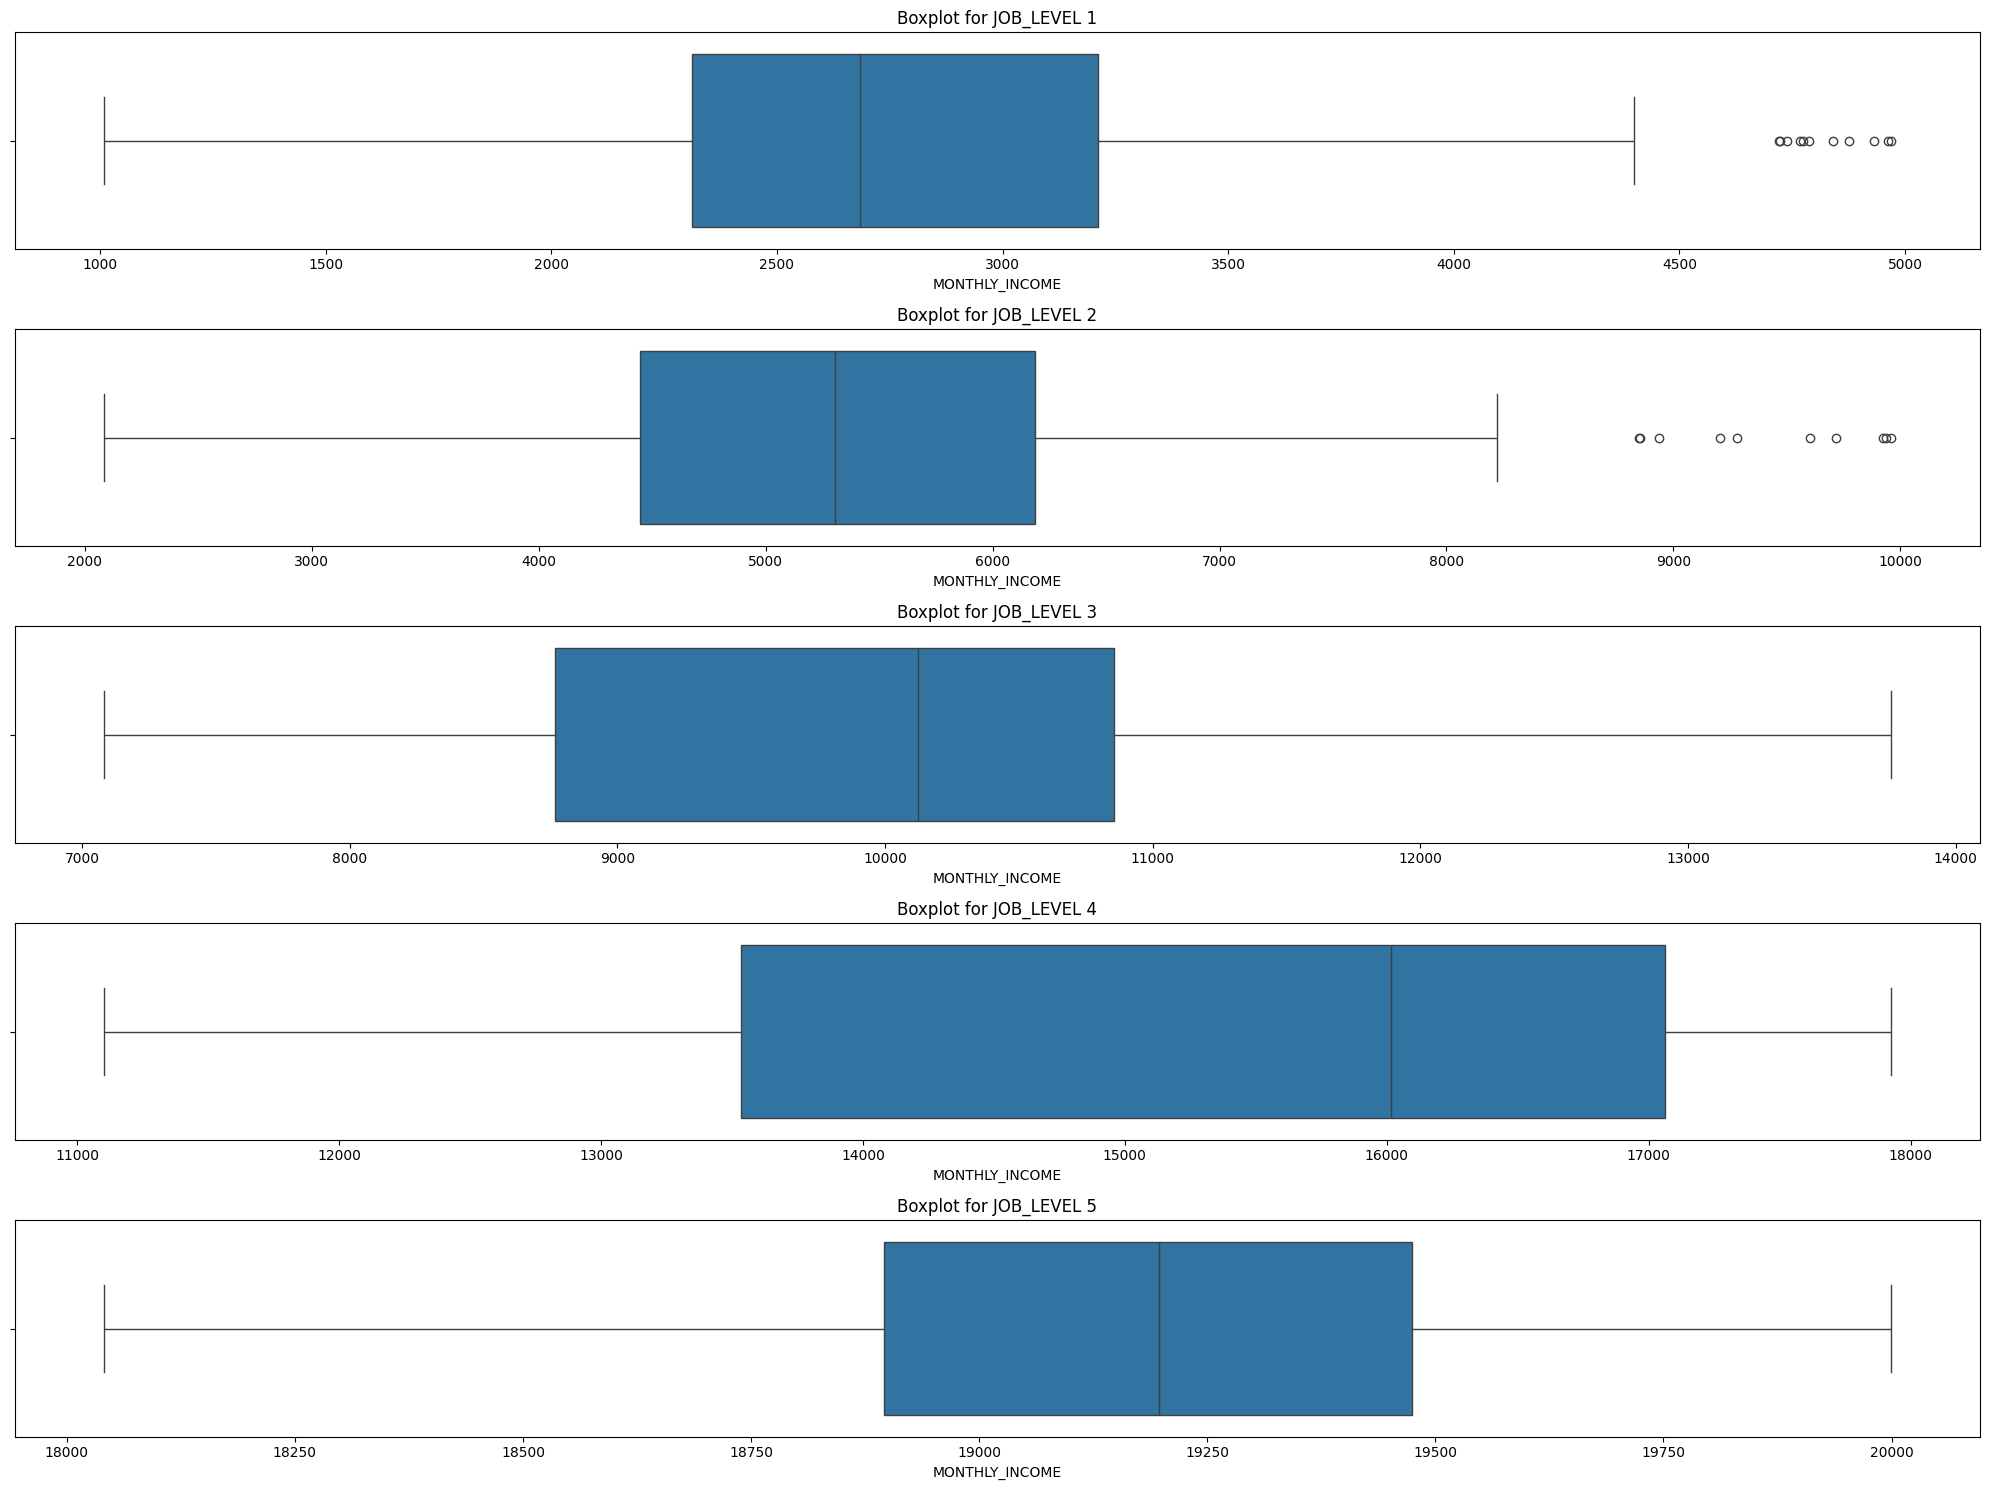

In [42]:
# Separamos el data frame por 'JOB_LEVEL'
df_level_income_1 = df_level_income[df_level_income['JOB_LEVEL'] == 1]
df_level_income_2 = df_level_income[df_level_income['JOB_LEVEL'] == 2]
df_level_income_3 = df_level_income[df_level_income['JOB_LEVEL'] == 3]
df_level_income_4 = df_level_income[df_level_income['JOB_LEVEL'] == 4]
df_level_income_5 = df_level_income[df_level_income['JOB_LEVEL'] == 5]

list_level_income = [df_level_income_1, df_level_income_2, df_level_income_3, df_level_income_4, df_level_income_5]

# Creamos el subplot con 5 filas y una columna
fig, axes = plt.subplots(5, 1, figsize=(20, 15))

for i, df_level_income_i in enumerate(list_level_income):
    sns.boxplot(x=df_level_income_i.columns[1], data=df_level_income_i, ax=axes[i])
    axes[i].set_title(f'Boxplot for JOB_LEVEL {i + 1}')

plt.tight_layout()
save_fig("boxplot_job_level")
plt.show()

En los boxplots anteriores observamos que no hay outliers para los JOB_LEVEL 3, 4 y 5, pero en cambio sí son relevantes para los JOB_LEVEL 1 y 2. 

En consecuencia crearemos una nueva columna llamada SALARY_LEVEL en este data frame temporal, que contenga la media redondeada para los JOB_LEVEL 3, 4 y 5, y la mediana para los JOB_LEVEL 1 y 2. Estos valores se utilizarán para sustituir los nulos de la columna JOB_LEVEL en el data frame principal.

In [43]:
df_level_income_grouped.T.columns

Index([1, 2, 3, 4, 5], dtype='int64', name='JOB_LEVEL')

In [44]:
df_level_income_grouped['SALARY_LEVEL'] = [df_level_income_grouped.iloc[0, 1] if i == 1 else (df_level_income_grouped.iloc[1, 1] if i == 2 else (round(df_level_income_grouped.iloc[2, 0]) if i == 3 else (round(df_level_income_grouped.iloc[3, 0]) if i ==4 else round(df_level_income_grouped.iloc[4, 0])))) for i in df_level_income_grouped.T.columns]

In [45]:
df_level_income_grouped.head()

MONTHLY_INCOME                SALARY_LEVEL
                    mean   median count             
JOB_LEVEL                                           
1            2811.113402   2683.0   291       2683.0
2            5391.410714   5304.0   280       5304.0
3           10007.184466  10124.0   103      10007.0
4           15340.706897  16015.0    58      15341.0
5           19132.461538  19197.0    39      19132.0

In [46]:
df_level_income_grouped.iloc[1, 3]

5304.0

In [47]:
for i in range(1,6):

    condicion = (df_types['JOB_LEVEL'] == i) & (pd.isna(df_types['MONTHLY_INCOME']))

    df_types.loc[condicion, 'MONTHLY_INCOME'] = df_level_income_grouped.iloc[(i-1), 3]

In [48]:
df_types.head()

AGE ATTRITION BUSINESS_TRAVEL  DISTANCE_FROM_HOME  EDUCATION  \
0   51        No             NaN                   6          3   
1   52        No             NaN                   1          4   
2   42        No   travel_rarely                   4          2   
3   47        No   travel_rarely                   2          4   
4   46        No             NaN                   3          3   

    EDUCATION_FIELD  ENVIRONMENT_SATISFACTION  GENDER  JOB_INVOLVEMENT  \
0               NaN                         1       0                3   
1     Life Sciences                         3       0                2   
2  Technical Degree                         3       0                3   
3           Medical                         1       1                3   
4  Technical Degree                         1       1                4   

   JOB_LEVEL             JOB_ROLE  JOB_SATISFACTION MARITAL_STATUS  \
0          5   resEArch DIREcToR                  3            NaN   
1          5             ManAGeR                  3            NaN   
2          5             ManaGER                  4        Married   
3          4   ReseArCH DIrECtOr                  3        Married   
4          4     sAleS EXECUtIve                  1       Divorced   

   MONTHLY_INCOME  MONTHLY_RATE  NUM_COMPANIES_WORKED OVER_TIME  \
0         19537.0          6462                     7        No   
1         19999.0          5678                     0       NaN   
2         19232.0          4933                     1        No   
3         17169.0         26703                     3       NaN   
4         15341.0          7739                     2        No   

   PERCENT_SALARY_HIKE  PERFORMANCE_RATING  RELATIONSHIP_SATISFACTION  \
0                   13                 3.0                          3   
1                   14                 3.0                          1   
2                   11                 3.0                          4   
3                   19                 3.0                          2   
4                   12                 3.0                          4   

   STOCK_OPTION_LEVEL  TOTAL_WORKING_YEARS  TRAINING_TIMES_LAST_YEAR  \
0                   0                  NaN                         5   
1                   1                 34.0                         5   
2                   0                 22.0                         3   
3                   2                  NaN                         2   
4                   1                  NaN                         5   

   WORK_LIFE_BALANCE  YEARS_AT_COMPANY  YEARS_SINCE_LAST_PROMOTION  \
0                3.0                20                          15   
1                3.0                33                          11   
2                NaN                22                          11   
3                NaN                20                           5   
4                3.0                19                           2   

   YEARS_WITH_CURR_MANAGER  DATE_BIRTH REMOTE_WORK  
0                       15        1972         Yes  
1                        9        1971           1  
2                       15        1981           1  
3                        6        1976       False  
4                        8        1977           0

## Columnas no numéricas
Primero vamos a comprobar los valores únicos

In [49]:
for i in df_types.select_dtypes(exclude='number').columns:
    print(i, df_types[i].unique())

ATTRITION ['No' 'Yes']
BUSINESS_TRAVEL [nan 'travel_rarely' 'travel_frequently' 'non-travel']
EDUCATION_FIELD [nan 'Life Sciences' 'Technical Degree' 'Medical' 'Other' 'Marketing'
 'Human Resources']
JOB_ROLE [' resEArch DIREcToR ' ' ManAGeR ' ' ManaGER ' ... ' sAlES ExECUTivE '
 ' SaLes ExecUtIVe ' ' mAnUfactURInG DiRECTOr ']
MARITAL_STATUS [nan 'Married' 'Divorced' 'Single' 'divorced' 'Marreid']
OVER_TIME ['No' nan 'Yes']
REMOTE_WORK ['Yes' '1' 'False' '0' 'True']


De la ejecución anterior, podemos inferir la necesidad de realizar varias acciones:

* En 'EDUCATION_FIELD' se sustituirán los espacios por _ y se pondrá todo en minúsculas.

* En 'JOB_ROLE' se eliminarán los espacios del principio y el final, se sustituirán los espacios centrales por _ y se pondrá todo en minúsculas.

* En 'MARITAL_STATUS' se pondrá todo en minúsculas y se cambiará 'marreid' por 'married'.

* En 'REMOTE_WORK' se sustituirán 'False' y '0' por 'No', y '1' por 'Yes'.

In [50]:
# Realizamos los cambios propuestos en 'EDUCATION_FIELD'
df_types['EDUCATION_FIELD'] = df_types['EDUCATION_FIELD'].str.replace(' ', '_').str.lower()

In [51]:
# Realizamos los cambios propuestos en 'JOB_ROLE'
df_types['JOB_ROLE'] = df_types['JOB_ROLE'].str.strip().str.replace(' ', '_').str.lower()

In [52]:
# Realizamos los cambios propuestos en 'MARITAL_STATUS'
df_types['MARITAL_STATUS'] = df_types['MARITAL_STATUS'].str.replace('Marreid', 'Married').str.lower()

In [53]:
# Realizamos los cambios propuestos en 'REMOTE_WORK'
remote = {'False': 'No',
          '0': 'No',
          '1': 'yes',
          'True': 'yes'} 

df_types['REMOTE_WORK'] = df_types['REMOTE_WORK'].replace(remote).str.lower()


In [54]:
df_types['REMOTE_WORK'].unique()

array(['yes', 'no'], dtype=object)

Además de estos cambios, la columna 'GENDER' tiene valores numéricos. Sustituiremos los 0 por F (de female) y los 1 por M (de male).

In [55]:
condicion_1 = df_types['GENDER'] == 0
condicion_2 = df_types['GENDER'] == 1

df_types.loc[condicion_1, 'GENDER'] = 'F'
df_types.loc[condicion_2, 'GENDER'] = 'M'

/tmp/ipykernel_112505/1135355244.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'F' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_types.loc[condicion_1, 'GENDER'] = 'F'


Por último, vamos a comprobar si hay duplicados

In [56]:
# Hay 59
df_types.duplicated().sum()

59

In [57]:
# Eliminamos los 59 duplicados
df_types.drop_duplicates(inplace=True)

In [58]:
# Comprobamos que han sido correctamente eliminados
df_types.duplicated().sum()

0

In [59]:
df_types.head()

AGE ATTRITION BUSINESS_TRAVEL  DISTANCE_FROM_HOME  EDUCATION  \
0   51        No             NaN                   6          3   
1   52        No             NaN                   1          4   
2   42        No   travel_rarely                   4          2   
3   47        No   travel_rarely                   2          4   
4   46        No             NaN                   3          3   

    EDUCATION_FIELD  ENVIRONMENT_SATISFACTION GENDER  JOB_INVOLVEMENT  \
0               NaN                         1      F                3   
1     life_sciences                         3      F                2   
2  technical_degree                         3      F                3   
3           medical                         1      M                3   
4  technical_degree                         1      M                4   

   JOB_LEVEL           JOB_ROLE  JOB_SATISFACTION MARITAL_STATUS  \
0          5  research_director                 3            NaN   
1          5            manager                 3            NaN   
2          5            manager                 4        married   
3          4  research_director                 3        married   
4          4    sales_executive                 1       divorced   

   MONTHLY_INCOME  MONTHLY_RATE  NUM_COMPANIES_WORKED OVER_TIME  \
0         19537.0          6462                     7        No   
1         19999.0          5678                     0       NaN   
2         19232.0          4933                     1        No   
3         17169.0         26703                     3       NaN   
4         15341.0          7739                     2        No   

   PERCENT_SALARY_HIKE  PERFORMANCE_RATING  RELATIONSHIP_SATISFACTION  \
0                   13                 3.0                          3   
1                   14                 3.0                          1   
2                   11                 3.0                          4   
3                   19                 3.0                          2   
4                   12                 3.0                          4   

   STOCK_OPTION_LEVEL  TOTAL_WORKING_YEARS  TRAINING_TIMES_LAST_YEAR  \
0                   0                  NaN                         5   
1                   1                 34.0                         5   
2                   0                 22.0                         3   
3                   2                  NaN                         2   
4                   1                  NaN                         5   

   WORK_LIFE_BALANCE  YEARS_AT_COMPANY  YEARS_SINCE_LAST_PROMOTION  \
0                3.0                20                          15   
1                3.0                33                          11   
2                NaN                22                          11   
3                NaN                20                           5   
4                3.0                19                           2   

   YEARS_WITH_CURR_MANAGER  DATE_BIRTH REMOTE_WORK  
0                       15        1972         yes  
1                        9        1971         yes  
2                       15        1981         yes  
3                        6        1976          no  
4                        8        1977          no

In [60]:
df_types.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1555 entries, 0 to 1611
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AGE                         1555 non-null   Int64  
 1   ATTRITION                   1555 non-null   object 
 2   BUSINESS_TRAVEL             812 non-null    object 
 3   DISTANCE_FROM_HOME          1555 non-null   int64  
 4   EDUCATION                   1555 non-null   int64  
 5   EDUCATION_FIELD             831 non-null    object 
 6   ENVIRONMENT_SATISFACTION    1555 non-null   int64  
 7   GENDER                      1555 non-null   object 
 8   JOB_INVOLVEMENT             1555 non-null   int64  
 9   JOB_LEVEL                   1555 non-null   int64  
 10  JOB_ROLE                    1555 non-null   object 
 11  JOB_SATISFACTION            1555 non-null   int64  
 12  MARITAL_STATUS              925 non-null    object 
 13  MONTHLY_INCOME              1555 non-n

## Outliers

Si bien para la base datos vamos a respetar todos los registros que nos hanquedado tras esta limpieza, para la visualización vamos echarle un ojo a los outliers.

In [61]:
df_types.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1555 entries, 0 to 1611
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AGE                         1555 non-null   Int64  
 1   ATTRITION                   1555 non-null   object 
 2   BUSINESS_TRAVEL             812 non-null    object 
 3   DISTANCE_FROM_HOME          1555 non-null   int64  
 4   EDUCATION                   1555 non-null   int64  
 5   EDUCATION_FIELD             831 non-null    object 
 6   ENVIRONMENT_SATISFACTION    1555 non-null   int64  
 7   GENDER                      1555 non-null   object 
 8   JOB_INVOLVEMENT             1555 non-null   int64  
 9   JOB_LEVEL                   1555 non-null   int64  
 10  JOB_ROLE                    1555 non-null   object 
 11  JOB_SATISFACTION            1555 non-null   int64  
 12  MARITAL_STATUS              925 non-null    object 
 13  MONTHLY_INCOME              1555 non-n

Saving figure outliers


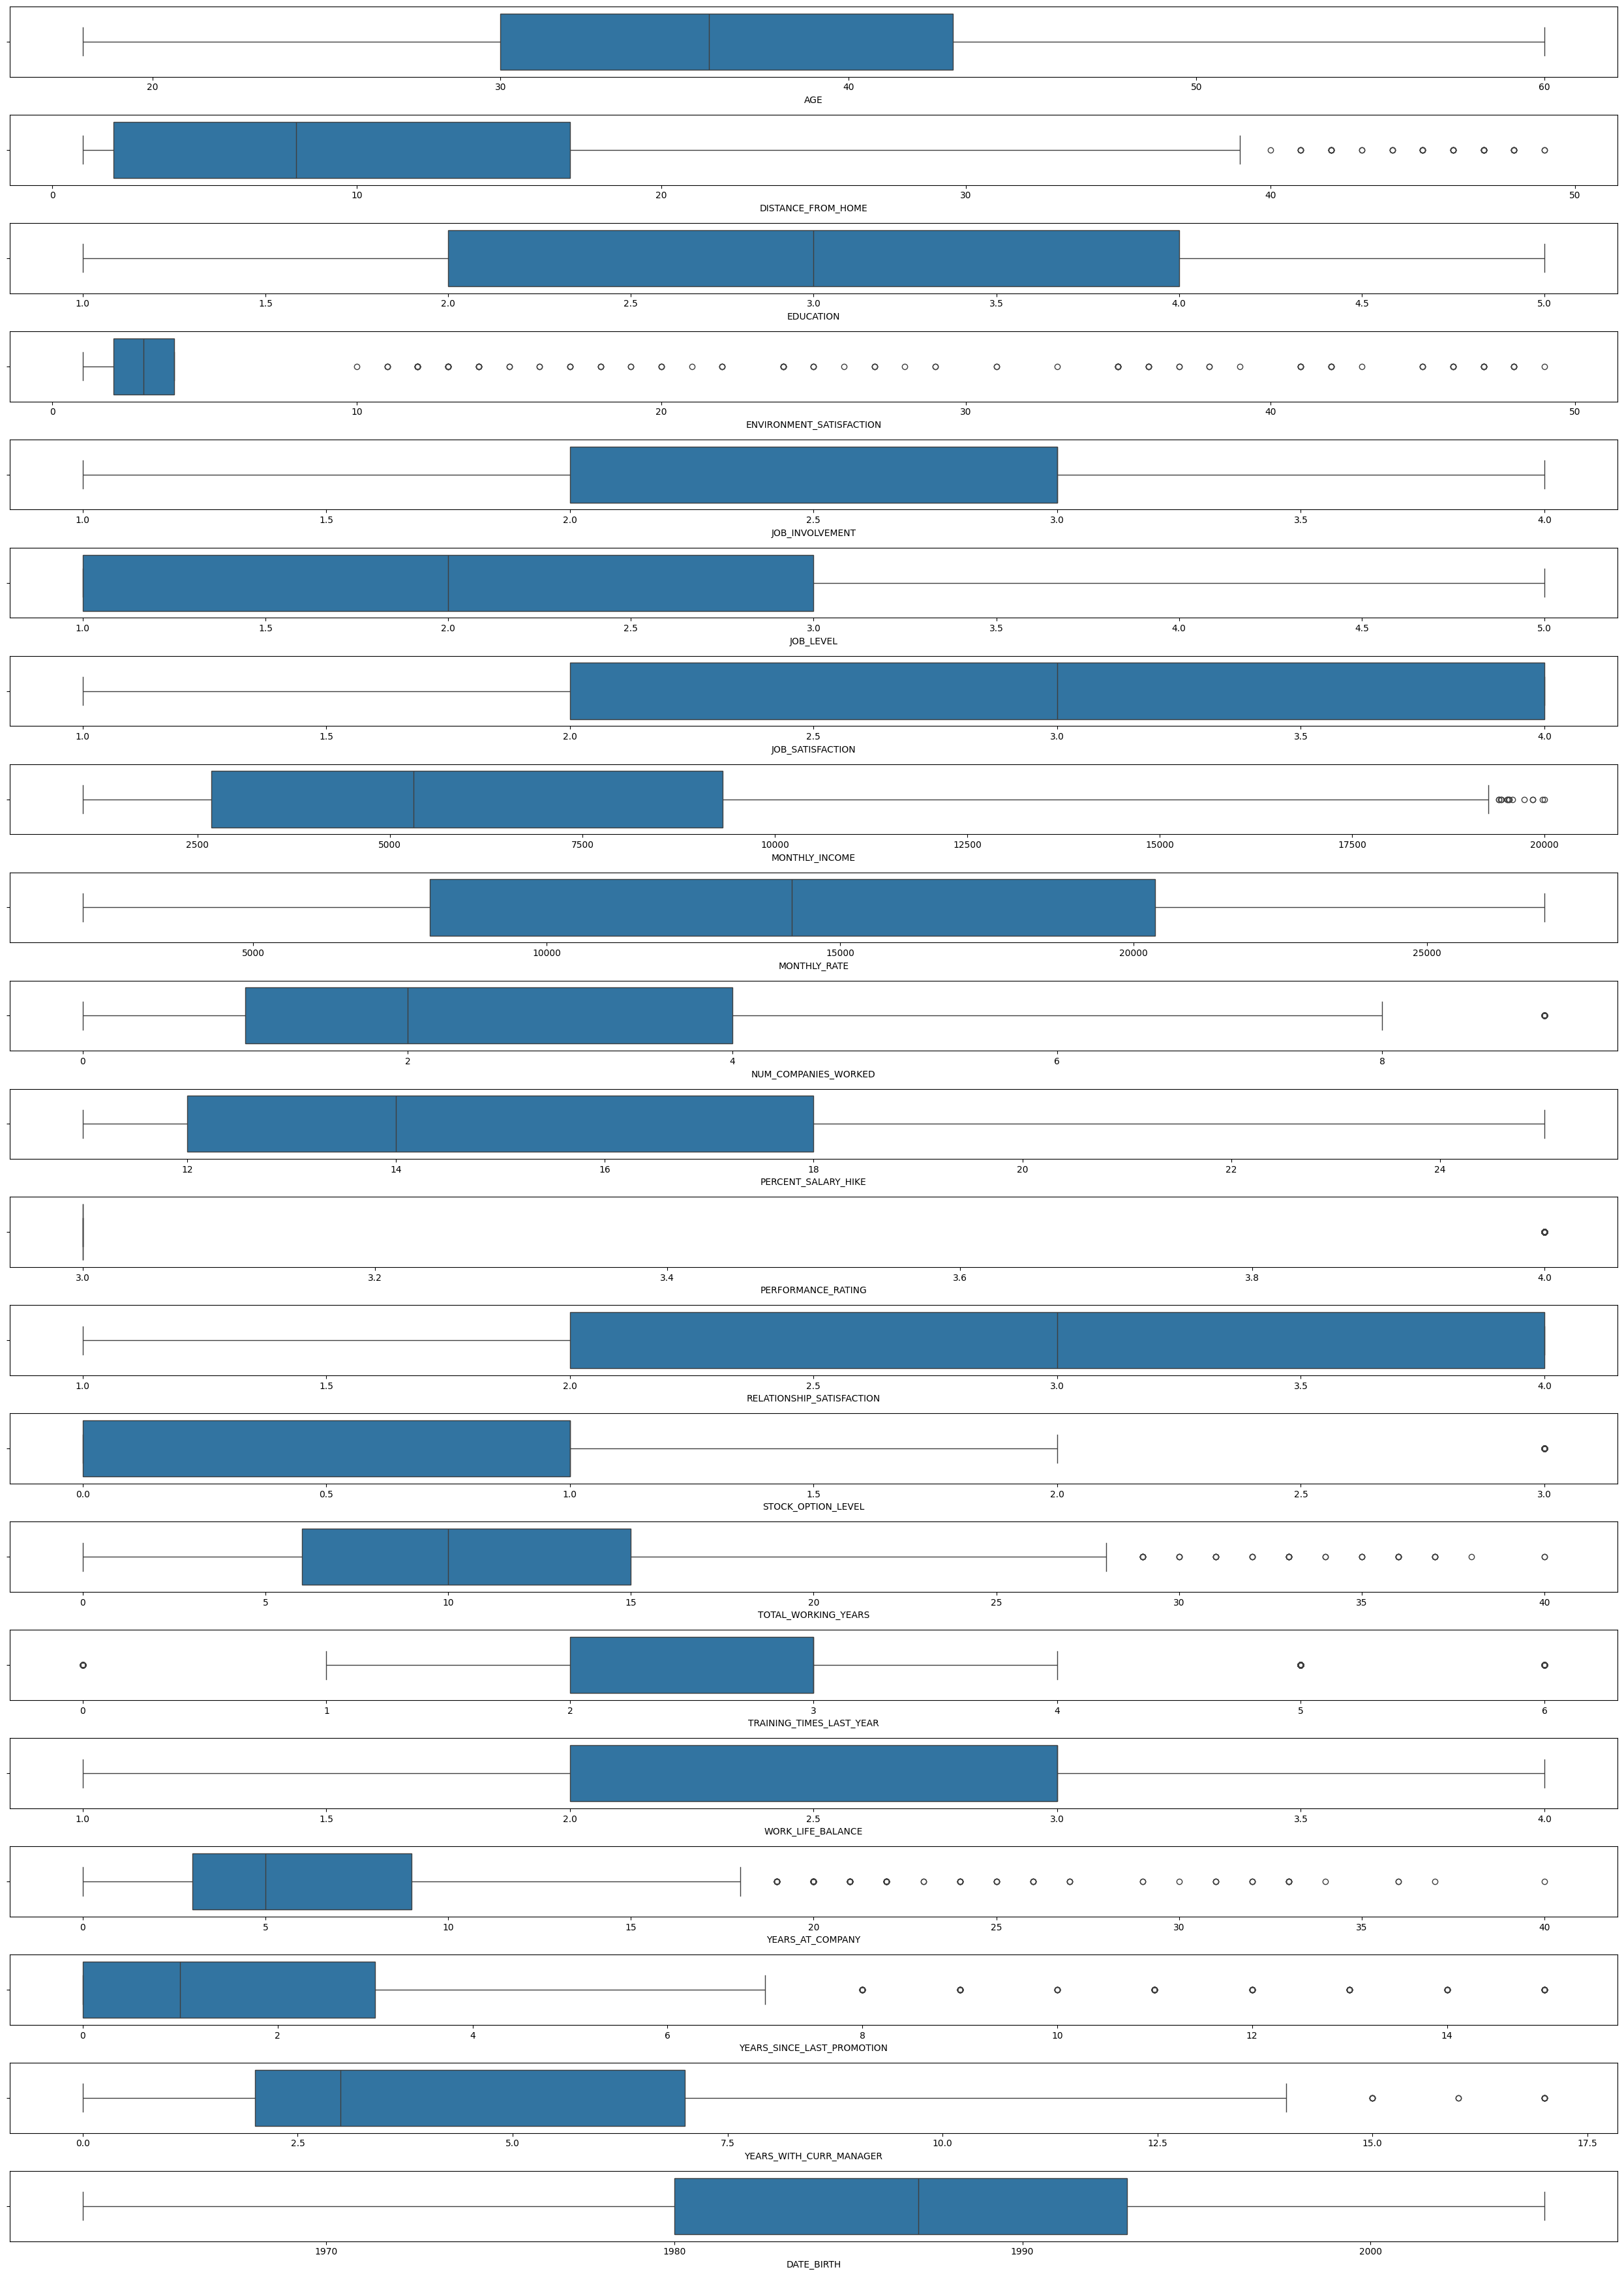

In [62]:
boxplot(21, df_types, nombre_fichero="outliers")

En base a nuestros intereses respecto a la visualización, vamos a comparar los datos de AGE (sin outliers) con los de YEARS_AT_COMPANY (que sí tiene outliers).

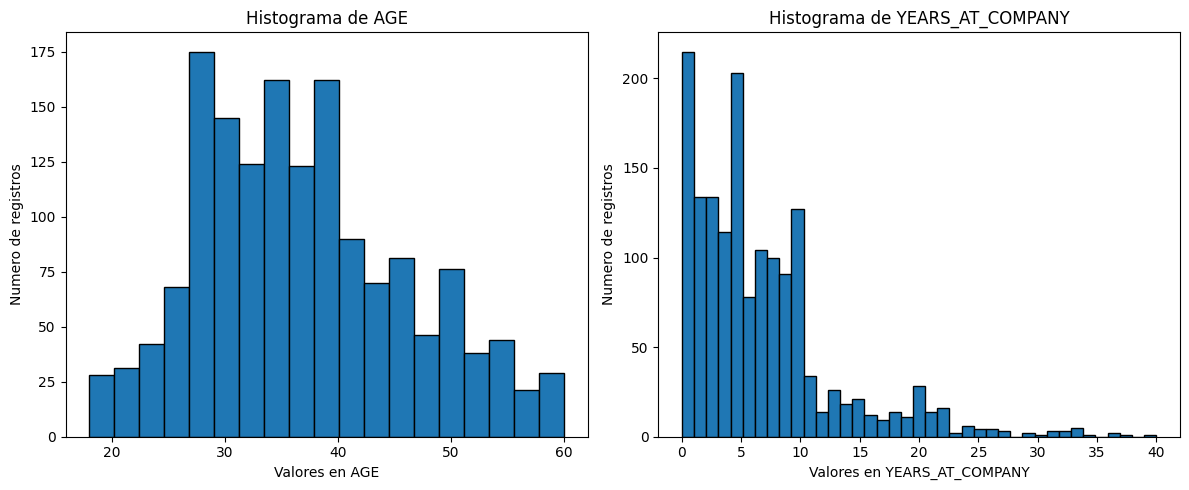

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot histogram for 'AGE'
axes[0].hist(df_types['AGE'], bins='auto', edgecolor='black')
axes[0].set_xlabel('Valores en AGE')
axes[0].set_ylabel('Numero de registros')
axes[0].set_title('Histograma de AGE')

# Plot histogram for 'YEARS_AT_COMPANY'
axes[1].hist(df_types['YEARS_AT_COMPANY'], bins='auto', edgecolor='black')
axes[1].set_xlabel('Valores en YEARS_AT_COMPANY')
axes[1].set_ylabel('Numero de registros')
axes[1].set_title('Histograma de YEARS_AT_COMPANY')

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined subplot
plt.show()

Observamos que AGE se acerca a una distribución normal, mientras que YEARS_AT_COMPANY tiene una buena cantidad de registros sueltos entrr los valores más elevados. Eliminaremos estos últimos, que arrastrará los outliers de otras columnas relacionadas como TOTAL_WORKING_YEARS, YEARS_SINCE_LAST_PROMOTION o YEAR_WITH_CURR_MANAGER.

In [64]:
# cálculo del Q1
""" Q1 = np.percentile(df_types['YEARS_AT_COMPANY'], 25)
Q1 """

" Q1 = np.percentile(df_types['YEARS_AT_COMPANY'], 25)\nQ1 "

In [65]:
# cálculo del Q3
""" Q3 = np.percentile(df_types['YEARS_AT_COMPANY'], 75)
Q3 """

" Q3 = np.percentile(df_types['YEARS_AT_COMPANY'], 75)\nQ3 "

In [66]:
#calculemos el IQR 
""" IQR = Q3 - Q1
IQR """

' IQR = Q3 - Q1\nIQR '

In [67]:
# multiplicamos el IQR por 1.5
""" outlier_step = 1.5 * IQR
outlier_step """

' outlier_step = 1.5 * IQR\noutlier_step '

In [68]:

# Filtramos nuestros datos
""" df_no_outliers = df_types[(df_types['YEARS_AT_COMPANY'] < Q1 - outlier_step) | (df_types['YEARS_AT_COMPANY'] > Q3 + outlier_step)] """

" df_no_outliers = df_types[(df_types['YEARS_AT_COMPANY'] < Q1 - outlier_step) | (df_types['YEARS_AT_COMPANY'] > Q3 + outlier_step)] "

In [69]:
""" dict_outliers = detectar_outliers(['YEARS_AT_COMPANY'], df_types) """

" dict_outliers = detectar_outliers(['YEARS_AT_COMPANY'], df_types) "

In [70]:
""" print(dict_outliers) """

' print(dict_outliers) '

In [71]:
df_types.shape

(1555, 29)

In [72]:
df_sin_outliers = eliminar_outliers(['YEARS_AT_COMPANY'], df_types)

In [73]:
df_sin_outliers.shape

(1448, 29)

Ahora vamos a eliminar los outliers para evitarnos ruido en la visualización.

# Guardado de los data frames en ficheros csv
Finalmente proceremos tanto a guardar el dataframe limpio que nos servirá para posteriores operaciones, como a dividirlo en dos separados por los valores de 'ATTRITION' y guardarlos par posteriormente comparar los resultados entre los trabajadores que abandonaron la empresa y los que siguen.

In [74]:
df_felices = df_types[(df_types['ATTRITION'] == 'No')]
df_tristes = df_types[(df_types['ATTRITION'] == 'Yes')]

In [76]:
df_types.to_csv("./data/empleados_limpio.csv")
df_felices.to_csv("./data/empleados_felices.csv")
df_tristes.to_csv("./data/empleados_tristes.csv")
df_sin_outliers.to_csv("./data/empleados_visualizacion.csv")